[View in Colaboratory](https://colab.research.google.com/github/Zulkhuu/head-gesture-recogniton/blob/master/python/head-pose-estimation/facial_keypoints_detection_colab.ipynb)

## Show System Specifications

In [0]:
from tensorflow.python.client import device_lib

print("Show System RAM Memory:\n\n")
!cat /proc/meminfo | egrep "MemTotal*"

print("\n\nShow Devices:\n\n"+str(device_lib.list_local_devices()))

Show System RAM Memory:


MemTotal:       13335276 kB


Show Devices:

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4590375382869261414
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 7258805912688096996
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 3659027285657020069
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11276946637
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5648094708007960081
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


## Download Dependencies to Google Colab Environment

This may take several minutes but needs to only be run once per session. Every Google Colab session has temporary storage for assets such as images and other scripts. When the session is closed these objects will be removed but the notebook will remain intact.

*Run the cell below to download necessary dependencies. After this is complete you can navigate to the FILES tab on the left and select refresh - you should see the files listed.*


In [56]:
!pip install PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

    100% |████████████████████████████████| 993kB 19.2MB/s 
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built PyDrive


In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
download = drive.CreateFile({'id': '1EsMyXP0aZJMI_aDcQPpc8FezCY-ibhK9'})
download.GetContentFile('facial-keypoints-detection.zip')

In [66]:
!unzip facial-keypoints-detection.zip -d data
!unzip data/training.zip -d data/

unzip:  cannot find or open facial-keypoints-detection.zip, facial-keypoints-detection.zip.zip or facial-keypoints-detection.zip.ZIP.
Archive:  data/training.zip
replace data/training.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data/training.csv       


# Loading the data 

The data we will use comes from a [Kaggle challenge](https://www.kaggle.com/c/facial-keypoints-detection#description) called *Facial Keypoints Detection*. I've downloaded the *.csv* file and put it in a *facial-keypoints-detection/* directory. Let's use pandas to read it.

In [0]:
import pandas as pd

In [0]:
df = pd.read_csv('data/training.csv')

In [69]:
df.head(3)

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...


In [70]:
df.shape

(7049, 31)

# Analyzing the data 

The `Image` column contains the face data for which the 30 first columns represent the keypoint data (15 x-coordinates and 15 y-coordinates). Let's try to get a feel for the data. First, let's display some faces.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
def string2image(string):
    """Converts a string to a numpy array."""
    return np.array([int(item) for item in string.split()]).reshape((96, 96))

def plot_faces(nrows=5, ncols=5):
    """Randomly displays some faces from the training data."""
    selection = np.random.choice(df.index, size=(nrows*ncols), replace=False)
    image_strings = df.loc[selection]['Image']
    fig, axes = plt.subplots(figsize=(10, 10), nrows=nrows, ncols=ncols)
    for string, ax in zip(image_strings, axes.ravel()):
        ax.imshow(string2image(string), cmap='gray')
        ax.axis('off')

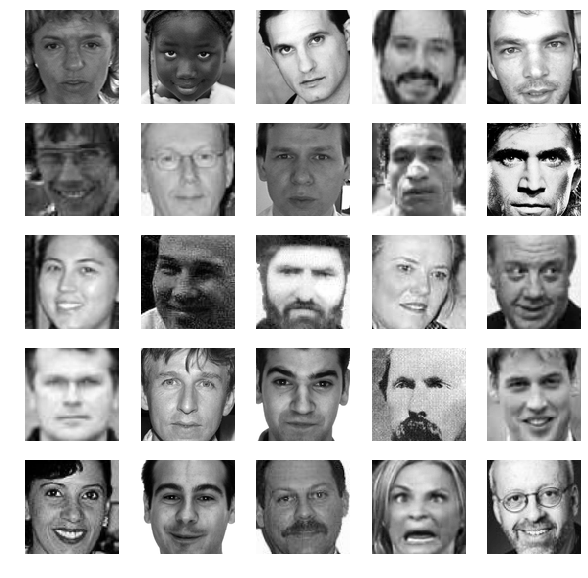

In [73]:
plot_faces()

Let's now add to that plot the facial keypoints that were tagged. First, let's do an example :

In [0]:
keypoint_cols = list(df.columns)[:-1]

In [75]:
xy = df.iloc[0][keypoint_cols].values.reshape((15, 2))
xy 

array([[66.0335639098, 39.0022736842],
       [30.2270075188, 36.4216781955],
       [59.582075188000005, 39.647422556399995],
       [73.1303458647, 39.9699969925],
       [36.3565714286, 37.3894015038],
       [23.4528721805, 37.3894015038],
       [56.9532631579, 29.0336481203],
       [80.2271278195, 32.2281383459],
       [40.2276090226, 29.0023218045],
       [16.3563789474, 29.6474706767],
       [44.4205714286, 57.0668030075],
       [61.1953082707, 79.9701654135],
       [28.6144962406, 77.38899248119999],
       [43.3126015038, 72.9354586466],
       [43.1307067669, 84.4857744361]], dtype=object)

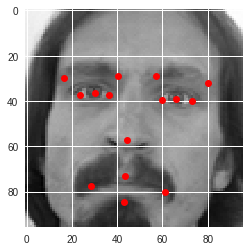

In [76]:
plt.plot(xy[:, 0], xy[:, 1], 'ro')
plt.imshow(string2image(df.iloc[0]['Image']), cmap='gray')

Now, let's add this to the function we wrote before.

In [0]:
def plot_faces_with_keypoints(nrows=5, ncols=5):
    """Randomly displays some faces from the training data with their keypoints."""
    selection = np.random.choice(df.index, size=(nrows*ncols), replace=False)
    image_strings = df.loc[selection]['Image']
    keypoint_cols = list(df.columns)[:-1]
    keypoints = df.loc[selection][keypoint_cols]
    fig, axes = plt.subplots(figsize=(10, 10), nrows=nrows, ncols=ncols)
    for string, (iloc, keypoint), ax in zip(image_strings, keypoints.iterrows(), axes.ravel()):
        xy = keypoint.values.reshape((15, 2))
        ax.imshow(string2image(string), cmap='gray')
        ax.plot(xy[:, 0], xy[:, 1], 'ro')
        ax.axis('off')

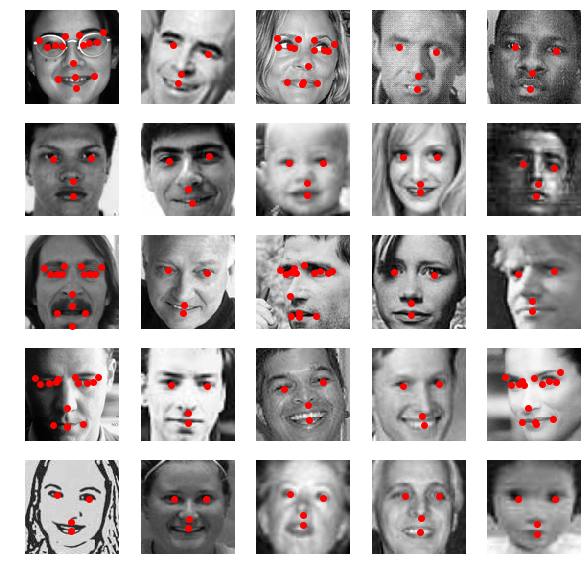

In [78]:
plot_faces_with_keypoints()

We can make several observations from this image: 

- some images are high resolution, some are low
- some images have all 15 keypoints, while some have only a few

Let's do some statistics about the keypoints to investigate that last observation :

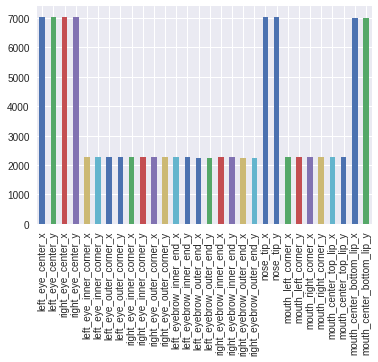

In [79]:
df.describe().loc['count'].plot.bar()

What this plot tells us is that in this dataset, only 2000 images are "high quality" with all keypoints, while 5000 other images are "low quality" with only 4 keypoints labelled.

Let's start training the data with the high quality images and see how far we get.

In [0]:
fully_annotated = df.dropna()

In [81]:
print(fully_annotated.shape)
print(fully_annotated['Image'].shape)

(2140, 31)
(2140,)


# Building a Keras model 

Now on to the machine learning part. Let's build a Keras model with our data. Actually, before we do that, let's do some preprocessing first, using the scikit-learn pipelines (inspired by [this great post on scalable Machine Learning by Tom Augspurger](https://tomaugspurger.github.io/scalable-ml-01.html)).

The idea behind pipelining is that it allows you to easily keep track of the data transformations applied to our data. We need two scalings: one for the input and one for the output. Since I couldn't get the scaling to work for 3d image data, we will only use a pipeline for our outputs.

In [0]:
X = np.stack([string2image(string) for string in fully_annotated['Image']]).astype(np.float)[:, :, :, np.newaxis]

In [0]:
y = np.vstack(fully_annotated[fully_annotated.columns[:-1]].values)

In [85]:
X.shape, X.dtype

((2140, 96, 96, 1), dtype('float64'))

In [86]:
y.shape, y.dtype

((2140, 30), dtype('float64'))

In [0]:
X_train = X / 255.

In [0]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

output_pipe = make_pipeline(
    MinMaxScaler(feature_range=(-1, 1))
)

y_train = output_pipe.fit_transform(y)

In this case, the pipelining process is, how to say this, not very spectacular. Let's move on and train a Keras model! We will start with a simple model, as found [in this blog post](http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/) with a fully connected layer and 100 hidden units.

In [89]:
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, Activation, MaxPooling2D, Dense, GlobalAveragePooling2D

Using TensorFlow backend.


# Define models 

In [0]:
from keras.layers import Dropout, Flatten

In [100]:
model = Sequential()
# input layer
model.add(BatchNormalization(input_shape=(96, 96, 1)))
model.add(Conv2D(24, (5, 5), kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))
# layer 2
model.add(Conv2D(36, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))
# layer 3
model.add(Conv2D(48, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))
# layer 4
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))
# layer 5
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(Flatten())
# layer 6
model.add(Dense(500, activation="relu"))
# layer 7
model.add(Dense(90, activation="relu"))
# layer 8
model.add(Dense(30))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [101]:
sgd = optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.95, nesterov=True)
model.compile(optimizer=sgd, loss='mse', metrics=['accuracy'])
epochs = 50
history = model.fit(X_train, y_train, 
                 validation_split=0.2, shuffle=True, 
                 epochs=epochs, batch_size=20)

Train on 1712 samples, validate on 428 samples
Epoch 1/50
1712/1712 [==============================] - 4s 3ms/step - loss: 0.0388 - acc: 0.3002 - val_loss: 0.0687 - val_acc: 0.0327
Epoch 2/50
1712/1712 [==============================] - 2s 1ms/step - loss: 0.0354 - acc: 0.3195 - val_loss: 0.0698 - val_acc: 0.0327
Epoch 3/50
1712/1712 [==============================] - 2s 1ms/step - loss: 0.0349 - acc: 0.3102 - val_loss: 0.0699 - val_acc: 0.0327
Epoch 4/50
1712/1712 [==============================] - 2s 1ms/step - loss: 0.0342 - acc: 0.3259 - val_loss: 0.0716 - val_acc: 0.0210
Epoch 5/50
1712/1712 [==============================] - 2s 999us/step - loss: 0.0325 - acc: 0.3172 - val_loss: 0.0670 - val_acc: 0.0327
Epoch 6/50
1712/1712 [==============================] - 2s 999us/step - loss: 0.0295 - acc: 0.3505 - val_loss: 0.0614 - val_acc: 0.0794
Epoch 7/50
1712/1712 [==============================] - 2s 1ms/step - loss: 0.0250 - acc: 0.4136 - val_loss: 0.0551 - val_acc: 0.1028
Epoch 8/50


Let's see that in curves: 

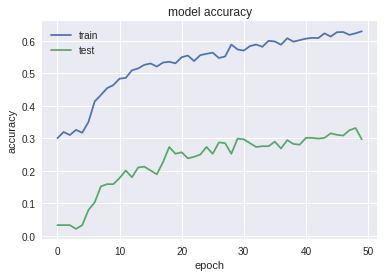

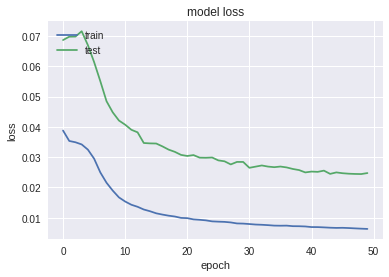

In [102]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

How good is the result?

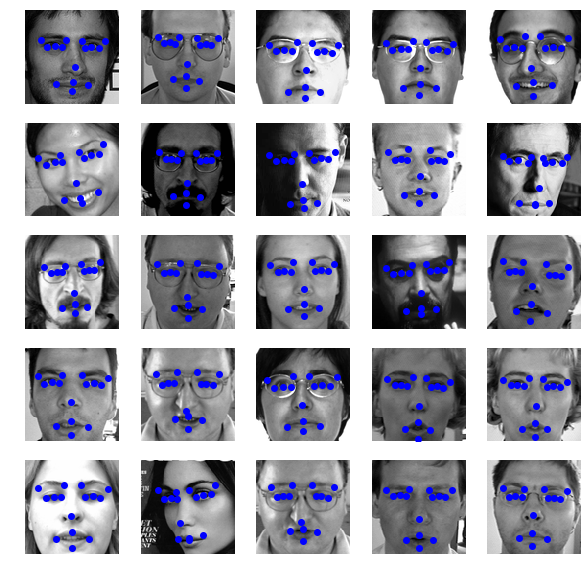

In [103]:
plot_faces_with_keypoints_and_predictions(model, model_input='2d')